In [75]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/home/cms/Desktop/LLP/cms_lpc_llp/jet_timing_studies/python/lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

# donotdelete = []
print(sys.version)

2.7.15rc1 (default, Nov 12 2018, 14:31:15) 
[GCC 7.3.0]


In [50]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()

bkg_path = "/home/cms/Desktop/LLP/delayed_jet_analyzer/"

lumi = 137000 #in pb-1

# fpath_bkg['WJetsToLNu'] = bkg_path+"jet_timing_studies_ntuple_RunIIFall17DRPremix_WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_withcheckflag.root"
fpath_bkg['bbbb'] = '/home/cms/Desktop/LLP/jetNtuple_RunIISummer16/withISR/bbbb/jet_timing_studies_ntuple_bbbb_vh_ISR_mh125_mx50_pl1000_ev100000.root'
for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['ntuples']['llp']
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["jetPt"].array()
    print (a[:-1][0])
    print(a.shape)

('bbbb', '/home/cms/Desktop/LLP/jetNtuple_RunIISummer16/withISR/bbbb/jet_timing_studies_ntuple_bbbb_vh_ISR_mh125_mx50_pl1000_ev100000.root')
[55.947124 50.37533  35.27962  22.545303]
(8292,)


In [51]:
trigger_names_file = '/home/cms/Desktop/LLP/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
    trigger_paths = [87,135] #PFMET120


# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET

In [87]:
for k,T in tree_bkg.items():
    # selections
    hlt = T['HLTDecision'].array()
    nJets = T['nJets'].array()
    jetEta = T['jetEta'].array()
    jetPt = T['jetPt'].array()

    
    sel_ev = np.ones(hlt[:,0].shape)
#     for tr in trigger_paths:
#         sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
    sel_ev = np.logical_and(sel_ev,nJets >= 2)

    jet_rechits_E = T['jet_rechits_E'].array()[sel_ev]
    jet_rechits_T = T['jet_rechits_T'].array()[sel_ev]
    jet_rechit_E_Ecut1 = T['jet_rechit_E_Ecut1'].array()[sel_ev]
    jet_rechit_T_Ecut1 = T['jet_rechit_T_Ecut1'].array()[sel_ev]
    jetEta = jetEta[sel_ev]
    jetPt = jetPt[sel_ev]
    
    jetChargedEMEnergyFraction = T['jetChargedEMEnergyFraction'].array()[sel_ev]
    jetNeutralEMEnergyFraction = T['jetNeutralEMEnergyFraction'].array()[sel_ev]
    jetChargedHadronEnergyFraction = T['jetChargedHadronEnergyFraction'].array()[sel_ev]
    jetNeutralHadronEnergyFraction = T['jetNeutralHadronEnergyFraction'].array()[sel_ev]
    
    
    test = jetNeutralEMEnergyFraction+jetChargedEMEnergyFraction+jetChargedHadronEnergyFraction+jetNeutralHadronEnergyFraction
    h_fraction = []
    em_fraction = []
    e_over_h = []
    jet_n_rechits = []
    reco_time = []
    for ev in range(len(jet_rechits_E)):
        rechit_count = []
        time_temp = []
        e_over_h_temp = []
        h_fraction_temp = []
        em_fraction_temp = []
        for j in range(len(jet_rechits_E[ev])):
            temp_t = jet_rechits_T[ev][j]
            temp_e = jet_rechits_E[ev][j]
            temp_t = temp_t[temp_e>1]
#             print(len(temp_t))
#             print(temp_t)
            if jet_rechit_E_Ecut1[ev][j] > 0 and abs(jetEta[ev][j])<2.4 and jetPt[ev][j]>20:
                rechit_count.append(np.count_nonzero(np.logical_not(temp_t==-666)))
                time_temp.append(jet_rechit_T_Ecut1[ev][j])
                h_fraction_temp.append(jetChargedHadronEnergyFraction[ev][j]+jetNeutralHadronEnergyFraction[ev][j])
                em_fraction_temp.append(jetNeutralEMEnergyFraction[ev][j]+jetChargedEMEnergyFraction[ev][j])
                e_over_h_temp.append((jetNeutralEMEnergyFraction[ev][j]+jetChargedEMEnergyFraction[ev][j])/(jetChargedHadronEnergyFraction[ev][j]+jetNeutralHadronEnergyFraction[ev][j]))
        if len(time_temp)>1:
            jet_n_rechits.append(np.array(rechit_count))
            reco_time.append(np.array(time_temp))
            e_over_h.append(np.array(e_over_h_temp))
            h_fraction.append(np.array(h_fraction_temp))
            em_fraction.append(np.array(em_fraction_temp))
    jet_n_rechits = np.array(jet_n_rechits)
    reco_time = np.array(reco_time)
    e_over_h = np.array(e_over_h)
    h_fraction = np.array(h_fraction)
    em_fraction = np.array(em_fraction)


#     jet_n_rechits = jet_n_rechits[sel_ev]
#     reco_time = reco_time[sel_ev]
    
    # choose most delayed jet
#     reco_time = np.array([np.max(x) for x in reco_time])
#     reco_time_index = [np.argmax(x) for x in reco_time]
#     jet_n_rechits = np.array([jet_n_rechits[i][reco_time_index[i]] for i in range(len(jet_n_rechits))])
#     e_over_h = np.array([e_over_h[i][reco_time_index[i]] for i in range(len(jet_n_rechits))])
#     h_fraction = np.array([h_fraction[i][reco_time_index[i]] for i in range(len(jet_n_rechits))])
#     em_fraction = np.array([em_fraction[i][reco_time_index[i]] for i in range(len(jet_n_rechits))])

    reco_time = np.array([y for x in reco_time for y in x])
    jet_n_rechits = np.array([y for x in jet_n_rechits for y in x])
    e_over_h = np.array([y for x in e_over_h for y in x])
    h_fraction = np.array([y for x in h_fraction for y in x])
    em_fraction = np.array([y for x in em_fraction for y in x])

    print(reco_time.shape)
    print(jet_n_rechits.shape)
    print(e_over_h.shape)
    print(jet_n_rechits[jet_n_rechits>25].shape)
    


    
#     sel_ev[k] = np.zeros(hlt[:,0].shape)

/home/cms/.local/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in float_scalars
/home/cms/.local/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in float_scalars


(10761,)
(10761,)
(10761,)
(51,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


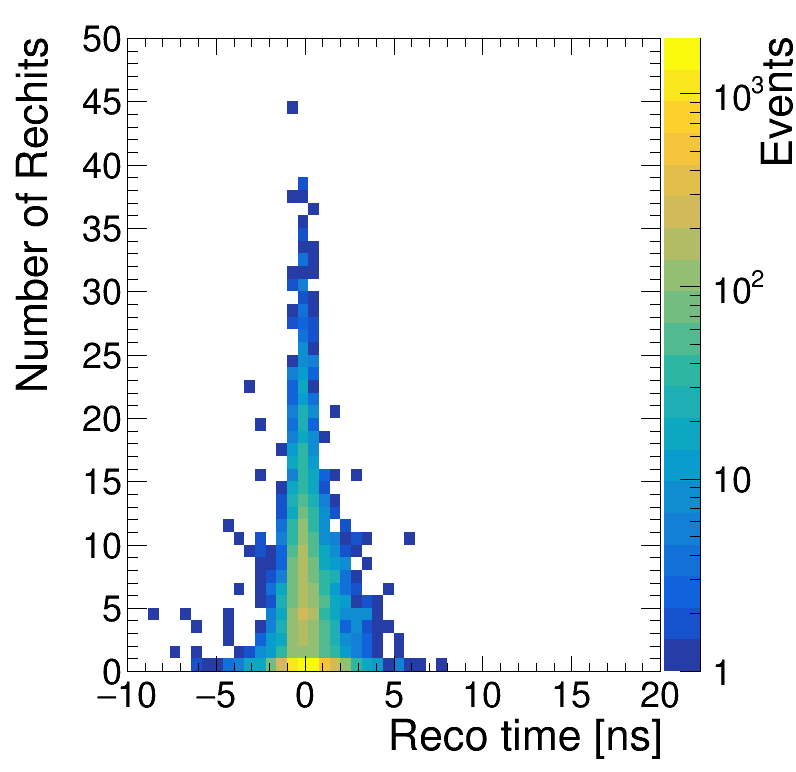

In [86]:
# Plotting mass
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.97,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
for k,v in tree_bkg.items():
#     print(v)
    h[k] = create_TH2D(np.column_stack((reco_time,jet_n_rechits)), axis_title = ['Reco time [ns]','Number of Rechits','Events'], binning=[50,-10,20,50,0,50])
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k], k)
    h[k].Draw('colz')
    i+=1

c.SetRightMargin(0.17)

# leg.Draw()


c.SetLogz()
c.Draw()



In [74]:
# Plotting mass
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.97,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
for k,v in tree_bkg.items():
#     print(v)
    h[k] = create_TH2D(np.column_stack((reco_time,h_fraction)), axis_title = ['Reco time [ns]','hadronic energy fraction','Events'], binning=[50,-10,20,50,0,1])
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k], k)
    h[k].Draw('colz')
    i+=1

c.SetRightMargin(0.17)

# leg.Draw()


c.SetLogz()
c.Draw()



ValueError: setting an array element with a sequence.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


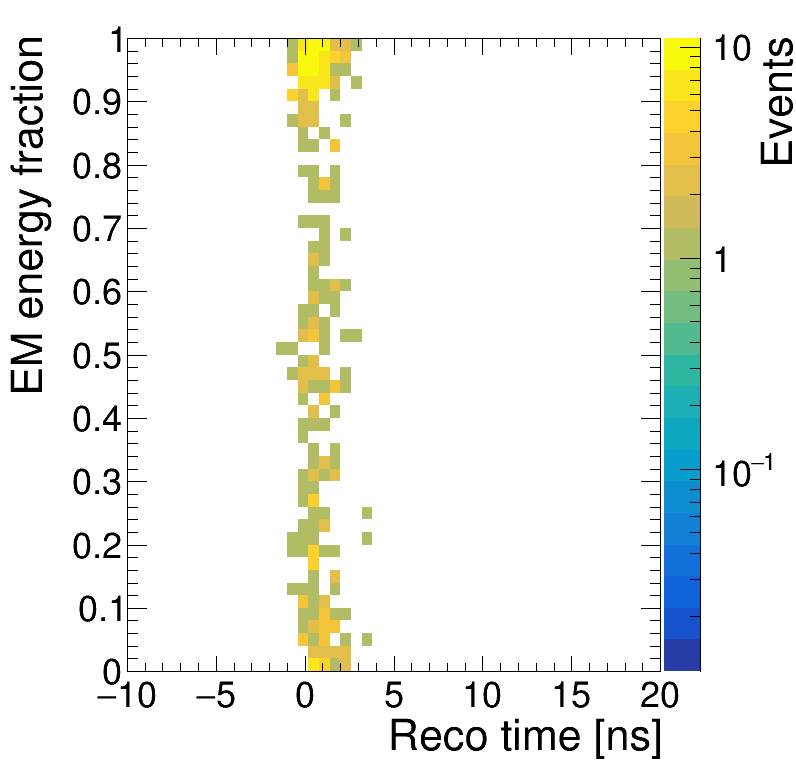

In [55]:
# Plotting mass
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.97,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
for k,v in tree_bkg.items():
#     print(v)
    h[k] = create_TH2D(np.column_stack((reco_time,em_fraction)), axis_title = ['Reco time [ns]','EM energy fraction','Events'], binning=[50,-10,20,50,0,1])
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k], k)
    h[k].Draw('colz')
    i+=1

c.SetRightMargin(0.17)

# leg.Draw()


c.SetLogz()
c.Draw()



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


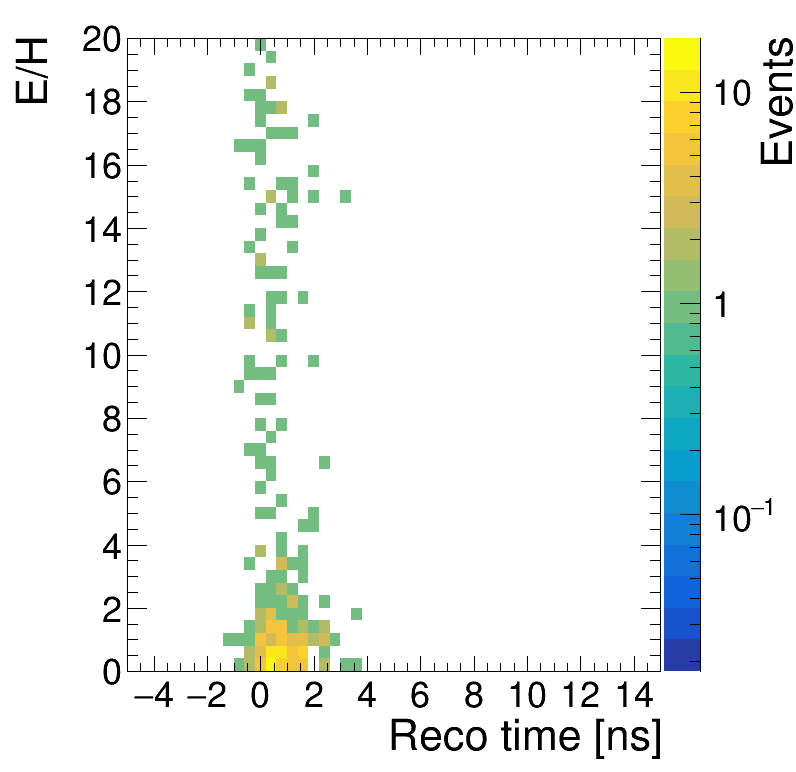

In [57]:
# Plotting mass
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.97,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
for k,v in tree_bkg.items():
#     print(v)
    h[k] = create_TH2D(np.column_stack((reco_time,e_over_h)), axis_title = ['Reco time [ns]','E/H','Events'], binning=[50,-5,15,50,0,20])
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k], k)
    h[k].Draw('colz')
    i+=1

c.SetRightMargin(0.17)

# leg.Draw()

# c.SetLogy()

c.SetLogz()
c.Draw()

